# Part I: Conformal Regression

We consider a simple regression problem on heteroskedastic data. We want to evaluate the uncertainty associated with the prediction using various conformal prediction methods. The main objective of this first part is to get a better grasp of how Conformal Prediction works, and to *visualize* the effect of the different algorithms on the coverage rate and the size of the prediction intervals. We will code most of the algorithms from scratch, and compare our results with those obtained with help of the PUNCC library for verification purposes.

**Links**
- [Github](https://github.com/deel-ai/puncc)
- [Documentation](https://deel-ai.github.io/puncc/index.html)

## 0. Setup

Install the puncc library using pip

In [3]:
!pip install puncc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.8/70.8 kB 3.1 MB/s eta 0:00:00


We import some modules and implement the function `evaluate_cp` that evaluates a conformal predictor on a new dataset by predicting intervals for the test inputs and computing the average width and coverage of these predictions, using a specified risk level $\alpha$.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from deel.puncc.metrics import regression_sharpness, regression_mean_coverage
import logging
from sklearn.model_selection import train_test_split

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

sns.set_theme()

warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(31)

## 1. Dataset

We consider a synthetic 1D heteroskedastic dataset, where the variance of the noise increases with the value of the input feature.
We generate $N$ samples as follows:

- Inputs $X$ are uniformly distributed on $[0, 20]$
- Outputs are given by $Y = (1+\epsilon)\cdot X, $

Such that $\epsilon \sim {\cal N}(\mu=0,\sigma=1)$ is standard gaussian noise.

**Exercise.** Generate the synthetic data for the regression task.

In [5]:
# Generate synthetic 1D heteroskedastic data

def heteroskedastic_data(n_samples):
    X = np.random.uniform(0, 20, n_samples)
    y = (1 + np.random.randn(n_samples)) * X
    X = X.reshape(-1, 1)
    return X, y

n_samples = 4_000
X, y = heteroskedastic_data(n_samples)

# # cast data to dtype float32
# X = X.astype(np.float32)
# y = y.astype(np.float32)

**Exercise.** Implement the function `plot_data` to visualize the synthetic data.

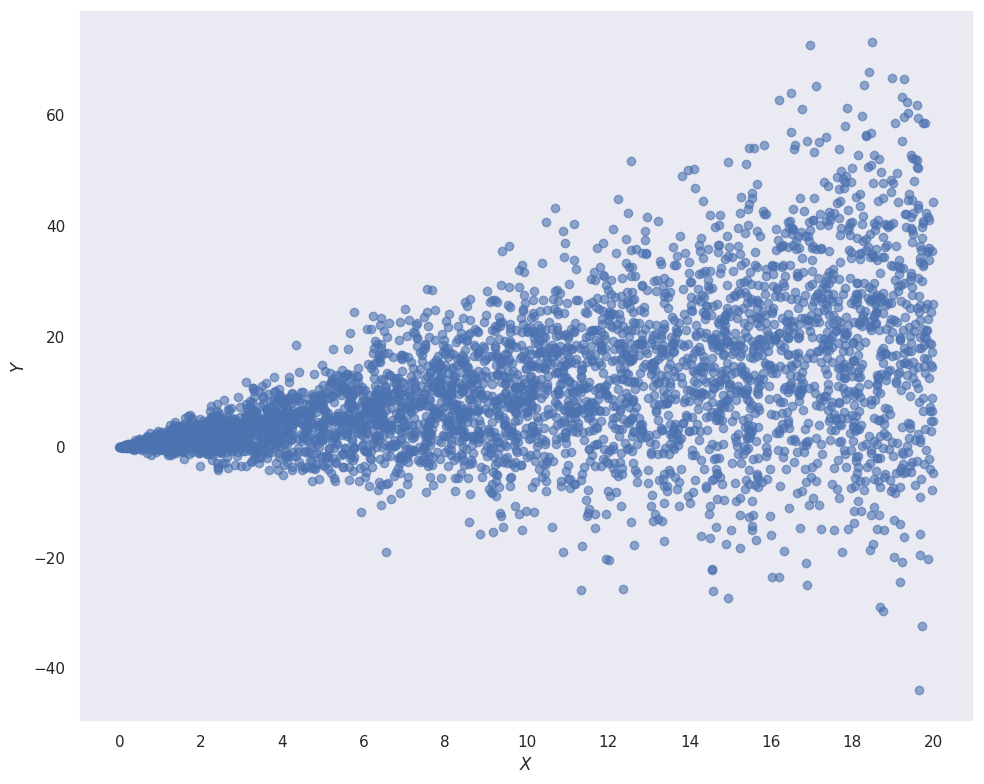

In [6]:
def plot_data(X, y):
    plt.figure(figsize=(10, 8))
    plt.scatter(X, y, alpha=0.6)
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()

plot_data(X, y)

**Exercise.** Split the data into a training set and a test set by using the `train_test_split` function of the `scikit-learn` library. Split the data randomly and leaving out 25% of the data for the test set.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=31
)

## 2. Split Conformal Regression

In order to perform the *split conformal regression* algorithm, we need to split our training data into a *proper training set* (which we will store in the variables `X_fit` and `y_fit`) and a *calibration set*.

**Exercise.** Further split the training data randomly by leaving out 50% of the training data for the calibration set.

In [8]:
X_fit, X_calib, y_fit, y_calib = train_test_split(X_train, y_train, test_size=0.5)

**Exercise.** Train a prediction model using the `LinearRegression` class in the `scikit-learn` library.

In [9]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

linear_model.fit(X_fit, y_fit)

LinearRegression()

**Exercise.** Plot the result of the linear model along with the test points.

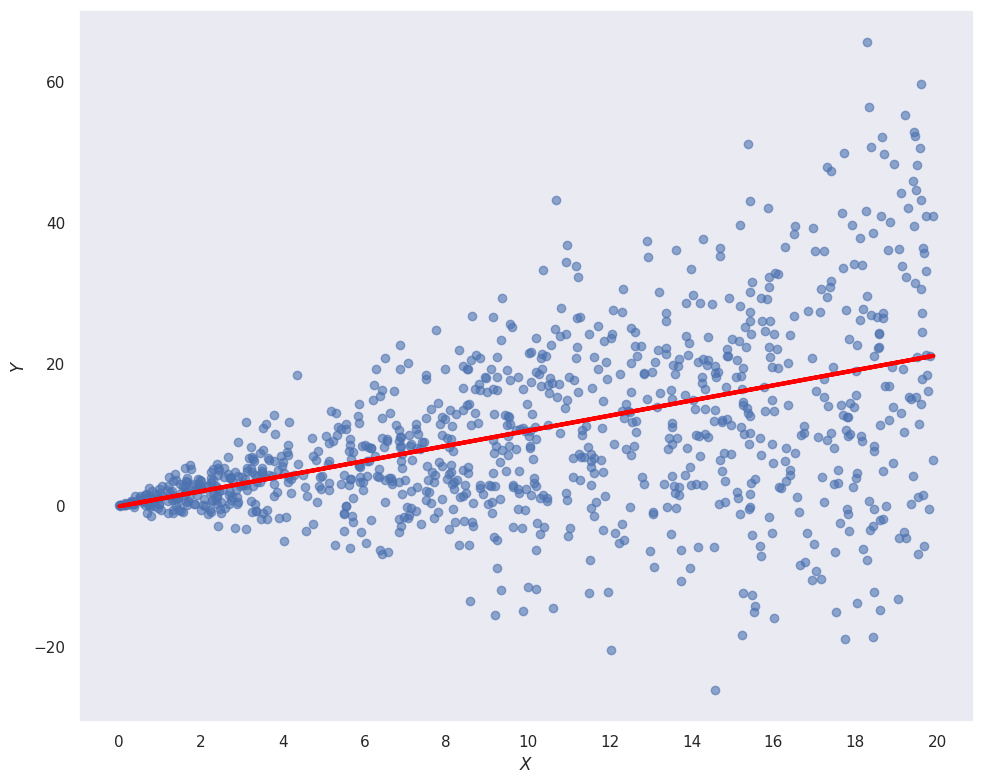

In [10]:
def plot_model(model, X, y):
    plt.figure(figsize=(10, 8))
    plt.scatter(X, y, alpha=0.6)
    plt.plot(X, model.predict(X), color="red", linewidth=3)
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()

plot_model(linear_model, X_test, y_test)

**Exercise.** Code the `SplitConformal` class.

In [11]:
class SplitConformal():
    def __init__(self, score_fn, predset_fn):
        self.score_fn = score_fn
        self.predset_fn = predset_fn
        self.scores = None
        self.quantile = None

    def compute_scores(self, y_calib, y_pred_calib):
        self.scores = self.score_fn(y_calib, y_pred_calib)

    def compute_quantile(self, alpha):
        corrected_alpha = np.ceil((1 - alpha) * (len(self.scores) + 1)) / len(self.scores)
        self.quantile = np.quantile(self.scores, corrected_alpha, method="inverted_cdf")

    def predict(self, y_test):
        return self.predset_fn(y_test, self.quantile)

**Exercise.** Code the `abs_difference` and `additive_interval` functions to be used as the arguments of the `SplitConformal` class at initialization.

In [12]:
def abs_difference(y_true, y_pred):
    return np.abs(y_true - y_pred)


def additive_interval(y, interval_length):
    return y - interval_length, y + interval_length

**Exercise.** Use the `SplitConformal` class to conformalize the Linear Regression model.

In [13]:
alpha = 0.1

y_pred_calib = linear_model.predict(X_calib)
splitcr = SplitConformal(abs_difference, additive_interval)
splitcr.compute_scores(y_calib, y_pred_calib)
splitcr.compute_quantile(0.1)

y_pred_test = linear_model.predict(X_test)
y_lower, y_upper = splitcr.predict(y_pred_test)

**Exercise.** Plot the model prediction along with the prediction intervals.

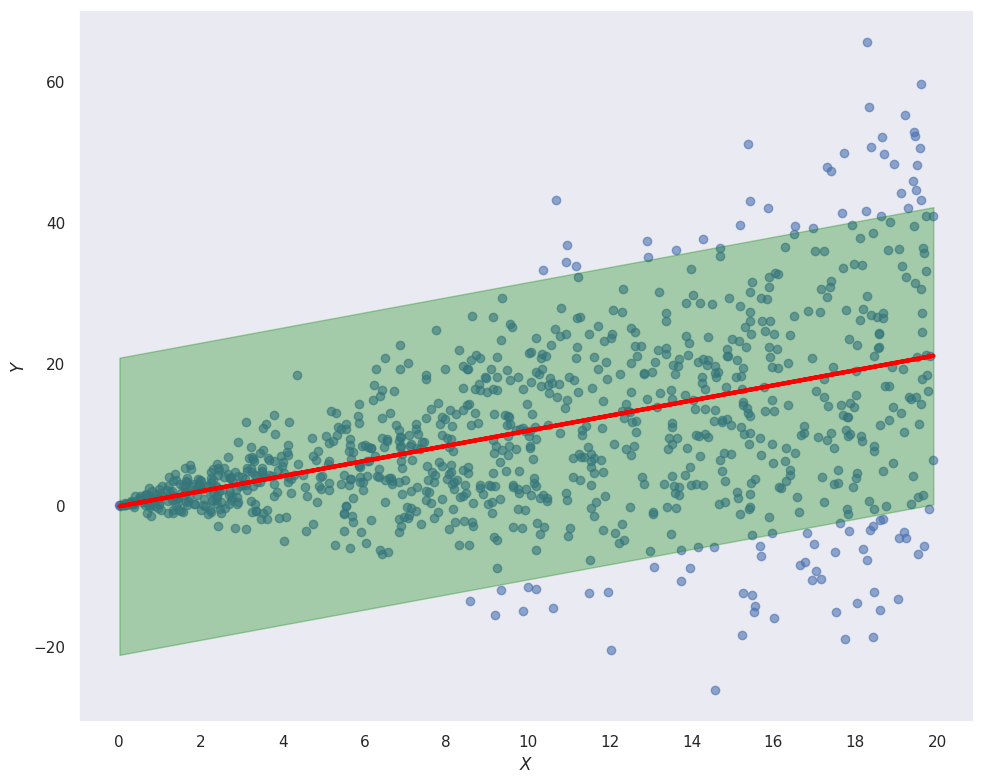

In [14]:
def plot_conformalized_data(X, y, y_pred, y_lower, y_upper):
    plt.figure(figsize=(10, 8))
    sort_indices = np.argsort(X.flatten())

    plt.scatter(X, y, alpha=0.6)
    plt.plot(X, y_pred, color="red", linewidth=3)
    plt.fill_between(
        X[sort_indices].flatten(),
        y_lower[sort_indices],
        y_upper[sort_indices],
        alpha=0.3,
        color="green",
    )
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()

plot_conformalized_data(X_test, y_test, y_pred_test, y_lower, y_upper)

**Exercise.** Evaluate the empirical coverage and average interval length of the conformalized model.

In [15]:
def evaluate_cp(X_test, y_test, y_lower, y_upper):
    coverage = np.mean((y_test >= y_lower) & (y_test <= y_upper))
    avg_length = np.mean(y_upper - y_lower)
    return coverage, avg_length

coverage, avg_length = evaluate_cp(X_test, y_test, y_lower, y_upper)
print(f"Average prediction intervals width (sharpness): {avg_length:.3f}")
print(f"Average coverage: {coverage:.3f}")

Average prediction intervals width (sharpness): 42.058
Average coverage: 0.910


The evaluation seems to match the desired results. Note however how the interval length is constant, and does not match the heteroskedasticity of the data.

Next, we perform a similar conformalization procedure using the PUNCC library, this will allow us to compare results, but also to learn how the PUNCC library works so that we can use it in the future instead of coding the CP algorithms from scratch.

In [16]:
from deel.puncc.api.prediction import BasePredictor
from deel.puncc.regression import SplitCP

# Initilize the linear_model again
linear_model = LinearRegression()

# Do not train the model yet, wrap it as a BasePredictor and let PUNCC do the job later.
base_predictor = BasePredictor(linear_model)

# Wrap the base predictor in a split conformal predictor
# train=True (default) to fit the split conformal predictor
splitcp = SplitCP(base_predictor)

# Fit the split conformal predictor:
# puncc will fit the underlying model on the fit data and
# compute nonconformity scores on the calibration set
splitcp.fit(X_fit=X_fit, y_fit=y_fit, X_calib=X_calib, y_calib=y_calib)

We now use punccs plotting and evaluation tools in order to visualizea and evaluate the results of the conformalization procedure.

Average prediction intervals width (sharpness): 0.910
Average coverage: 42.058


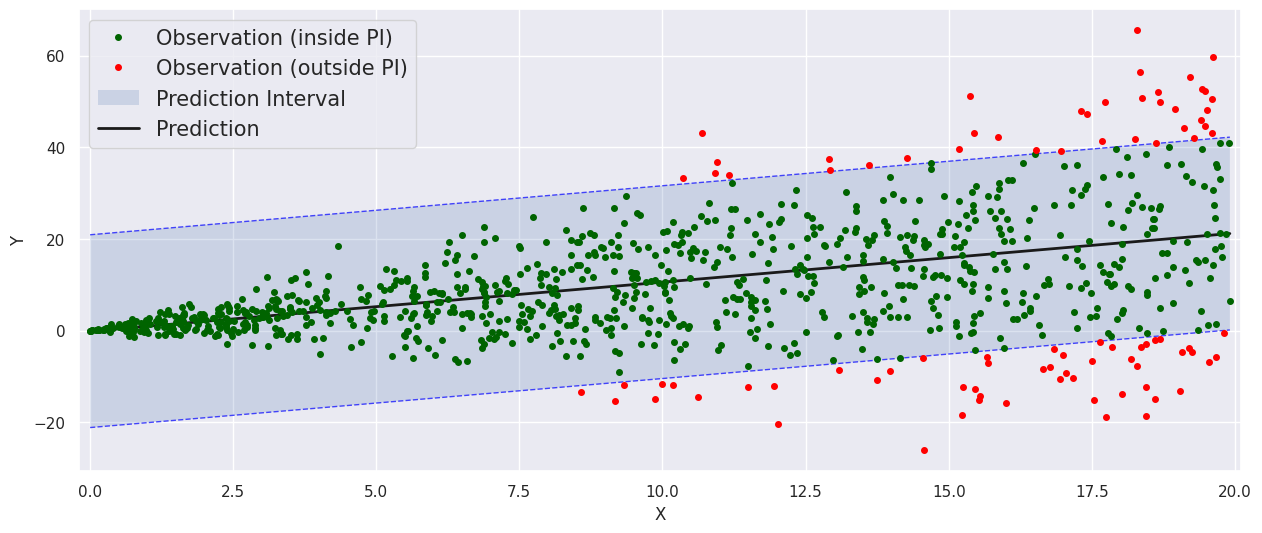

In [17]:
from deel.puncc.plotting import plot_prediction_intervals

# Maximum allowed error rate
alpha = 0.1

# Compute prediction intervals and metrics on the test set
y_pred, y_pred_lower, y_pred_upper = splitcp.predict(X_test, alpha=alpha)  # TODO

# Evaluate the sharpness and coverage of the prediction intervals
sharpness, coverage = evaluate_cp(X_test, y_test, y_pred_lower, y_pred_upper)
print(f"Average prediction intervals width (sharpness): {sharpness:.3f}")
print(f"Average coverage: {coverage:.3f}")

# Plot the prediction intervals
plot_prediction_intervals(
    y_true=y_test,
    y_pred_lower=y_pred_lower,
    y_pred_upper=y_pred_upper,
    y_pred=y_pred,
    X=X_test[:, 0],
)
plt.show()

## 3. Cross-Validation+ (CV+)
Next we will implement the *Cross-Validation+* algorithm, which allows to use the whole training dataset for training, instead of splitting it into a proper training set and a calibration set. Of course, this comes at the cost of having to train multiple models.

**Exercise.** Train 10 different linear regression models using the `KFold` class from the `sklearn.model_selection` model. Store the different models and scores for use during the calibration phase.

In [18]:
from sklearn.model_selection import KFold

# Define the k-fold cross-validation scheme
kf = KFold(n_splits = 10, shuffle = True, random_state = 31)

# Initialize empty lists to store models and scores
models = []
scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):

    # Split the data into training and validation sets
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Initialize the linear model
    linear_model = LinearRegression()

    # Train the model
    linear_model.fit(X_train_fold, y_train_fold)
    models.append(linear_model)

    # Compute predictions on the validation set
    y_pred_val = linear_model.predict(X_val_fold)

    # Compute nonconformity scores and append to lists
    scores.append(abs_difference(y_val_fold, y_pred_val))

# concatenate scores into a numpy array
scores = np.concatenate(scores)

**Exercise.** Use the *CV+* algorithm to produce prediction intervals for nominal $\alpha=0.1$. Compute point predictions on the test set by averaging accross the 10 different models.

In [19]:
# Compute Prediction intervals:

# Set value of nominal error rate alpha
alpha = 0.1

# Initialize lower and upper arrays
y_pred_test = []
y_lower = []
y_upper = []

for fold, (train_index, val_index) in enumerate(kf.split(scores)):

    # Compute predictions on k-th model
    y_pred = models[fold].predict(X_test)
    y_pred_test.append(y_pred)

    # Extract scores
    scores_fold = scores[val_index]

    # Update lower and upper arrays
    y_lower.append(y_pred[:, np.newaxis] - scores_fold[np.newaxis, :])
    y_upper.append(y_pred[:, np.newaxis] + scores_fold[np.newaxis, :])


# Convert the lists y_lower and y_upper into numpy arrays
y_pred_test = np.stack(y_pred_test)
y_lower = np.concatenate(y_lower, axis=1)
y_upper = np.concatenate(y_upper, axis=1)

# Compute predictions by averaging over the k models
y_pred_test = np.mean(y_pred_test, axis=0)

# Compute prediction intervals using the numpy quantile function
alpha_lower_corrected = np.floor(alpha * (len(scores) + 1)) / len(scores)
alpha_upper_corrected = np.ceil((1 - alpha) * (len(scores) + 1)) / len(scores)
y_lower = np.quantile(y_lower, alpha_lower_corrected, axis=1, method="inverted_cdf")
y_upper = np.quantile(y_upper, alpha_upper_corrected, axis=1, method="inverted_cdf")

**Exercise.** Plot the results

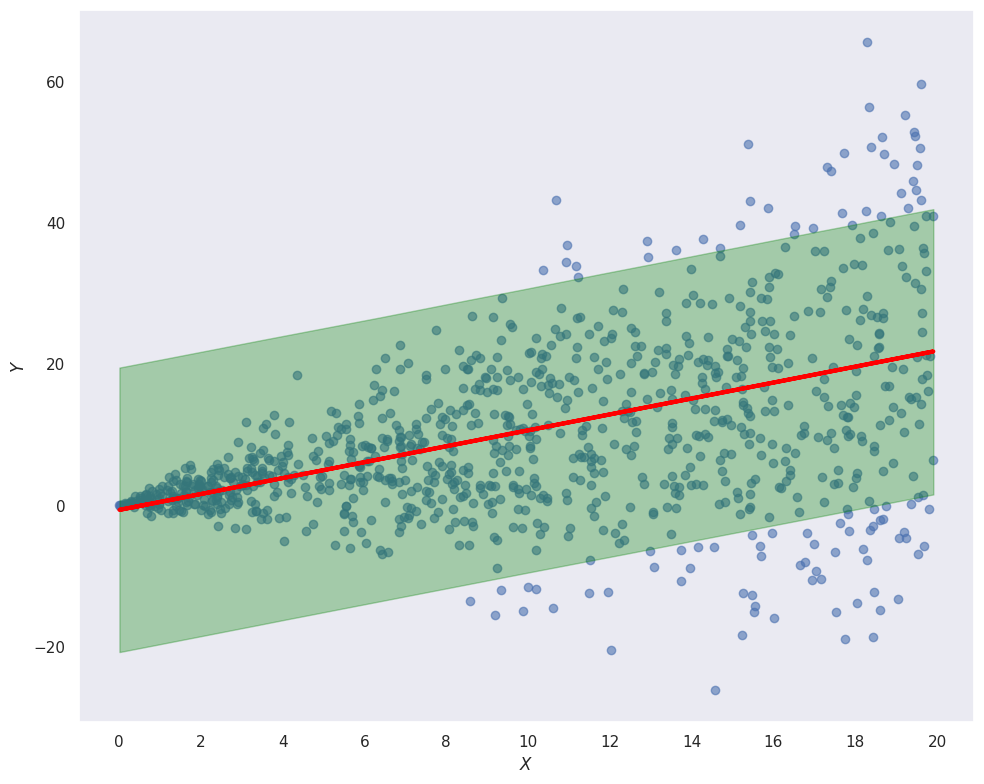

Average prediction intervals width (sharpness): 40.259
Average coverage: 0.897


In [20]:
def plot_conformalized_data(X, y, y_pred, y_lower, y_upper):
    plt.figure(figsize=(10, 8))
    sort_indices = np.argsort(X.flatten())

    plt.scatter(X, y, alpha=0.6)
    plt.plot(X, y_pred, color="red", linewidth=3)
    plt.fill_between(
        X[sort_indices].flatten(),
        y_lower[sort_indices],
        y_upper[sort_indices],
        alpha=0.3,
        color="green",
    )
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()

plot_conformalized_data(X_test, y_test, y_pred_test, y_lower, y_upper)

# Evaluate the conformalized model
coverage, avg_length = evaluate_cp(X_test, y_test, y_lower, y_upper)
print(f"Average prediction intervals width (sharpness): {avg_length:.3f}")
print(f"Average coverage: {coverage:.3f}")

**Exercise.** Perform the Cross-Validation using PUNCC and compare the results.

Average prediction intervals width (sharpness): 0.897
Average coverage: 40.261


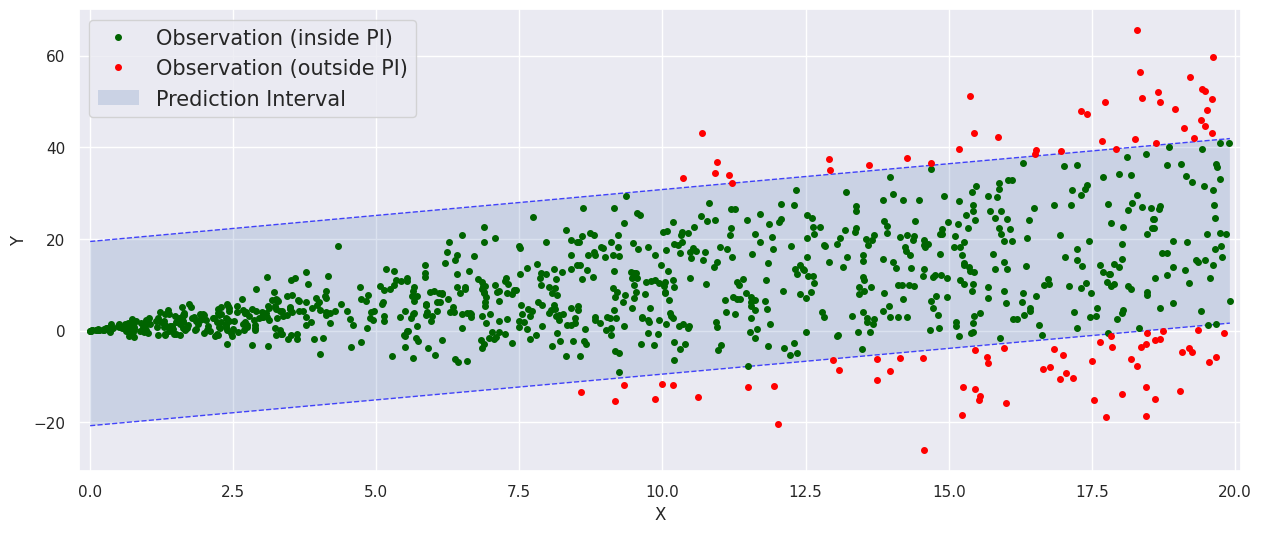

In [21]:
from deel.puncc.regression import CVPlus

# Wrap the base predictor in a split conformal predictor, choose K=5
cvplus = CVPlus(base_predictor, K=10, random_state=31)  # TODO

# Fit the CV+ predictor
cvplus.fit(X=X_train, y=y_train)

# Compute prediction intervals and metrics on the test set
y_pred, y_pred_lower, y_pred_upper = cvplus.predict(X_test, alpha=0.1)  # TODO

# Evaluate the sharpness and coverage of the prediction intervals
sharpness, coverage = evaluate_cp(X_test, y_test, y_pred_lower, y_pred_upper)
print(f"Average prediction intervals width (sharpness): {sharpness:.3f}")
print(f"Average coverage: {coverage:.3f}")

# Plot the prediction intervals
plot_prediction_intervals(
    y_true=y_test,
    y_pred_lower=y_pred_lower,
    y_pred_upper=y_pred_upper,
    y_pred=y_pred,
    X=X_test[:, 0],
)
plt.show()

Note that whereas the guarantee provided by the Jacknife+ method is
$$\mathbb{P}(Y_{n+1}\in \hat{C}_\alpha(X_{n+1})) \geq 1-2\alpha,$$
the achieved coverage rate is rather close to $1-\alpha$.

**Question.** How can you explain this?

## 4. Conformal Quantile Regression

Let's now consider Conformalized Quantile Regression (CQR). CQR extends traditional quantile regression by incorporating conformal prediction techniques, allowing us to construct predictive intervals with state-of-the-art performance and guaranteed coverage (under data exchangeability).

**Exercise.** Train lower and upper quantile models using the `GradientBoostingRegressor` model from the `sklearn.ensemble` module. **Careful!** The CQR algorithm is a kind of *split conformal* algorithm, so we neet to use the *fit* data split to train the models, and hold out the *calibration* data split for the calibration phase.

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

# Lower quantile regressor
lower_quantile_model = GradientBoostingRegressor(
    loss="quantile", alpha=alpha / 2, n_estimators=10
)
# Upper quantile regressor
upper_quantile_model = GradientBoostingRegressor(
    loss="quantile", alpha=1 - alpha / 2, n_estimators=10
)

# Train the models
lower_quantile_model.fit(X_fit, y_fit)
upper_quantile_model.fit(X_fit, y_fit)

GradientBoostingRegressor(alpha=0.95, loss='quantile', n_estimators=10)

**Exercise.** Plot the results.

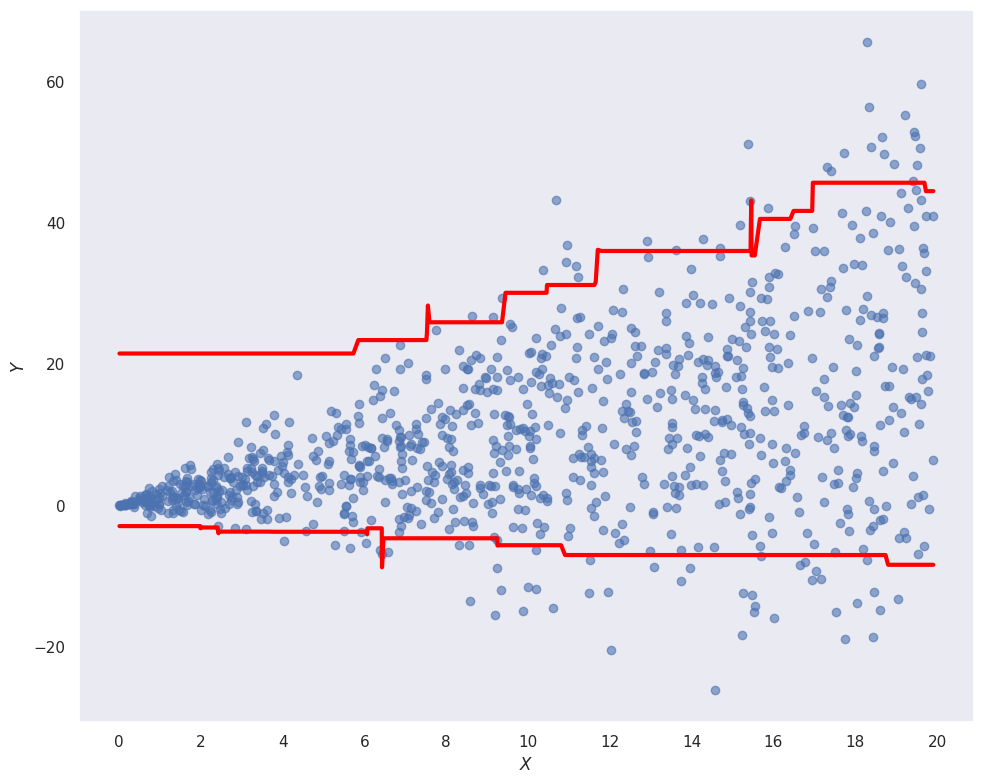

In [23]:
def plot_quantile_models(X, y, lower_quantile_model, upper_quantile_model):
    plt.figure(figsize=(10, 8))
    sort_indices = np.argsort(X.flatten())
    X_sorted = X[sort_indices]
    y_sorted = y[sort_indices]
    plt.scatter(X, y, alpha=0.6)
    plt.plot(X_sorted, lower_quantile_model.predict(X_sorted), color="red", linewidth=3)
    plt.plot(X_sorted, upper_quantile_model.predict(X_sorted), color="red", linewidth=3)
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()


plot_quantile_models(X_test, y_test, lower_quantile_model, upper_quantile_model)

**Exercise.** Code the functions `cqr_score` and `cqr_set` so that we can use them along with the class `SplitConformal` above in order to implement the CQR algorithm.

In [24]:
def cqr_score(y_true, y_pred):
    return np.max(np.stack([y_pred[0] - y_true, y_true - y_pred[1]]), axis=0)

def cqr_set(y_pred, quantile):
    return y_pred[0] - quantile, y_pred[1] + quantile

**Exercise.** Conformalize the quantile regressors using the CQR algorithm.

In [25]:
y_pred_calib_lower = lower_quantile_model.predict(X_calib)
y_pred_calib_upper = upper_quantile_model.predict(X_calib)
y_pred_calib = np.stack([y_pred_calib_lower, y_pred_calib_upper])

alpha = 0.1

splitcr = SplitConformal(cqr_score, cqr_set)

splitcr.compute_scores(y_calib, y_pred_calib)
splitcr.compute_quantile(alpha)

y_pred_test_lower = lower_quantile_model.predict(X_test)
y_pred_test_upper = upper_quantile_model.predict(X_test)
y_pred_test = np.stack([y_pred_test_lower, y_pred_test_upper])
y_lower, y_upper = splitcr.predict(y_pred_test)

**Exercise.** Plot and visualize the results. Evaluate the performance of the CQR conformalized model.

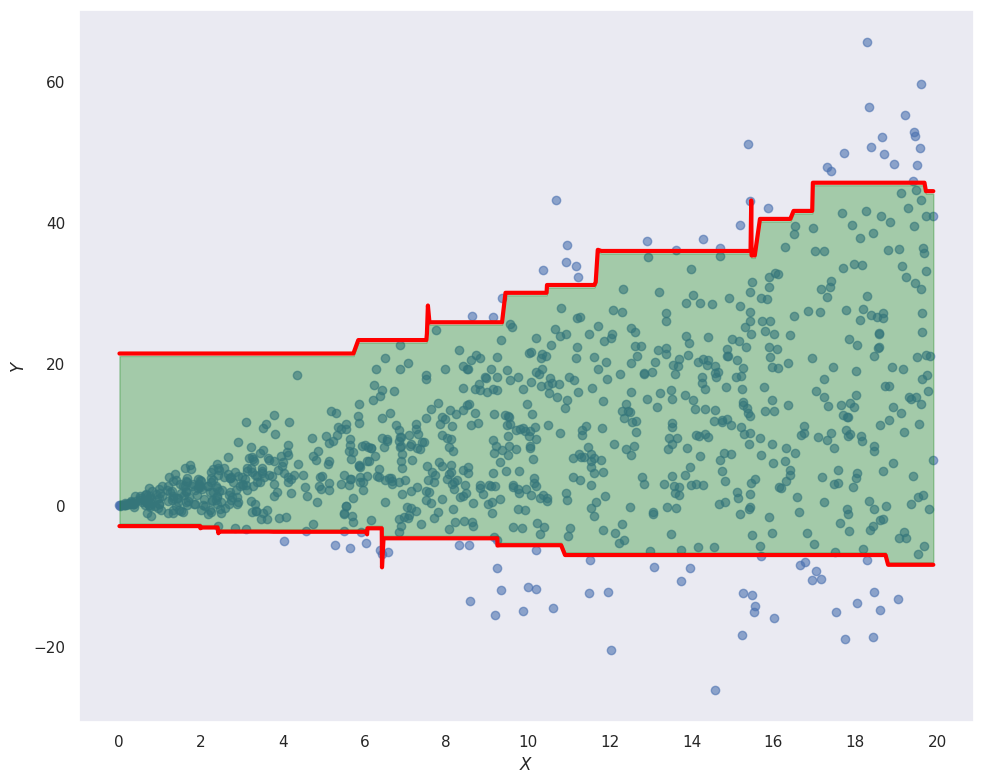

Average prediction intervals width (sharpness): 35.577
Average coverage: 0.916


In [26]:
def plot_cqr_conformalized_data(X, y, y_pred_lower, y_pred_upper, y_lower, y_upper):
    plt.figure(figsize=(10, 8))
    sort_indices = np.argsort(X.flatten())
    X_sorted = X[sort_indices]
    y_pred_lower_sorted = y_pred_lower[sort_indices]
    y_pred_upper_sorted = y_pred_upper[sort_indices]
    y_lower_sorted = y_lower[sort_indices]
    y_upper_sorted = y_upper[sort_indices]

    plt.scatter(X, y, alpha=0.6)
    plt.plot(X_sorted, y_pred_lower_sorted, color="red", linewidth=3)
    plt.plot(X_sorted, y_pred_upper_sorted, color="red", linewidth=3)
    plt.fill_between(
        X_sorted.flatten(),
        y_lower_sorted,
        y_upper_sorted,
        alpha=0.3,
        color="green",
    )
    plt.xlabel(r"$X$")
    plt.ylabel(r"$Y$")
    plt.xticks(np.arange(22, step=2))
    plt.tight_layout()
    plt.grid(False)
    plt.show()

plot_cqr_conformalized_data(X_test, y_test, y_pred_test_lower, y_pred_test_upper, y_lower, y_upper)

coverage, avg_length = evaluate_cp(X_test, y_test, y_lower, y_upper)
print(f"Average prediction intervals width (sharpness): {avg_length:.3f}")
print(f"Average coverage: {coverage:.3f}")

**Questions.**
- What do you observe?
- Is this the expected behavior? Why?
- How does the average interval width compare with the previous methods?

**Exercise.** Implement the CQR algorithm in with PUNCC and compare the results with the ones obtained above.

Average prediction intervals width (sharpness): 0.912
Average coverage: 36.210


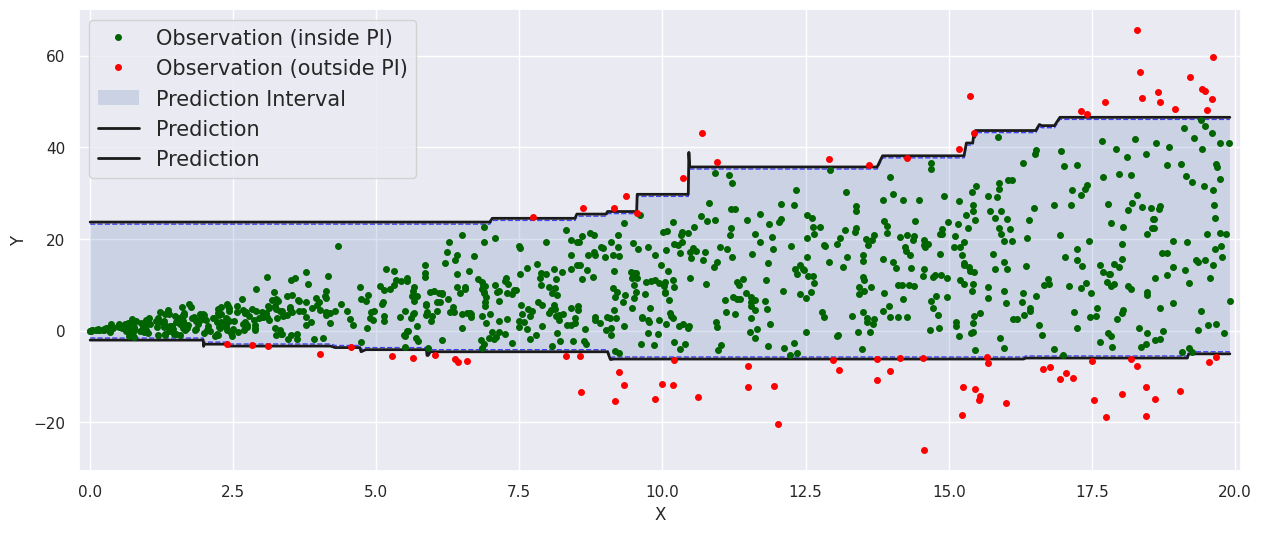

In [27]:
from deel.puncc.api.prediction import DualPredictor
from deel.puncc.regression import CQR

# Wrap the upper and lower quantile models in a dual predictor
dualpredictor = DualPredictor([lower_quantile_model, upper_quantile_model])

# Initialize the CQR conformal predictor
# train=True to use the train dual predictor
cqr = CQR(dualpredictor, train=True)

# Fit the CQR predictor and compute the nonconformity scores
cqr.fit(X=X_train, y=y_train, fit_ratio=0.5)

# Compute prediction intervals and metrics on the test set
y_pred, y_lower, y_upper = cqr.predict(X_test, alpha)  # TODO

# Evaluate the sharpness and coverage of the prediction intervals
sharpness, coverage = evaluate_cp(X_test, y_test, y_lower, y_upper)

print(f"Average prediction intervals width (sharpness): {sharpness:.3f}")
print(f"Average coverage: {coverage:.3f}")

# Plot the prediction intervals
plot_prediction_intervals(
    y_pred=y_pred,
    y_true=y_test,
    y_pred_lower=y_lower,
    y_pred_upper=y_upper,
    X=X_test[:, 0],
)
plt.show()

# Part II: Conformal Classification

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


**Exercise.** Load the data and split the training set into a proper training set and a calibration set.

In [29]:
# MNIST dataset (downloaded and transformed to tensors)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transform, download=True)

# Split data into fit and calib sets
total_size = len(train_dataset)

# Calculate sizes for fit and calibration datasets
fit_size = int(0.9 * total_size)
calib_size = total_size - fit_size

# Split the dataset
fit_dataset, calib_dataset = random_split(train_dataset, [fit_size, calib_size])

# Print the sizes of the subsets
print(f"Fit dataset size: {len(fit_dataset)}")
print(f"Calibration dataset size: {len(calib_dataset)}")

# DataLoader for batching
batch_size = 64
fit_loader = DataLoader(dataset=fit_dataset, batch_size=batch_size, shuffle=True)
calib_loader = DataLoader(dataset=calib_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 505kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.81MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.09MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Fit dataset size: 54000
Calibration dataset size: 6000


**Exercise.** Train a simple neural network on the MNIST fit dataset.

In [30]:
# Hyperparameters
input_size = 28 * 28  # MNIST images are 28x28
num_classes = 10  # 10 classes for digits 0-9
learning_rate = 0.0001
num_epochs = 1

# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First fully connected layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)         # Second fully connected layer
        self.fc3 = nn.Linear(64, num_classes)  # Output layer

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss, and optimizer
model = SimpleNN(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    for images, labels in fit_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Testing loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch [1/1], Loss: 0.5394
Test Accuracy: 89.19%


## 1. Least Ambiguous Set-Valued Classifiers (LAC)

**Exercise.** Define a `lac_score` and a `lac_set` function in order to be used with the `SplitConformal` class above.

In [31]:
def lac_score(probas, labels):
    scores = [1 - p[l] for p, l in zip(probas, labels)]
    return np.array(scores)

def lac_set(probas, quantile):
    return [np.where(p > 1 - quantile)[0] for p in probas]

**Exercise.** Compute the softmax probabilities on the calibration data. Use a temperature parameter to avoid softmax values that are too close to 0 and 1.

In [32]:
def softmax_temp(logits, temp):
    exp_logits = np.exp(logits / temp)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

In [73]:
X_calib, y_calib = calib_dataset.dataset.data[calib_dataset.indices], calib_dataset.dataset.targets[calib_dataset.indices]
X_test, y_test = test_dataset.data.numpy(), test_dataset.targets.numpy()

X_calib = X_calib.reshape(len(X_calib), -1).numpy() # Added .numpy() here
y_calib = y_calib.numpy()
X_test = X_test.reshape(len(X_test), -1)

y_pred_calib = model(torch.from_numpy(X_calib).float().to(device))
y_pred_calib = y_pred_calib - torch.max(y_pred_calib, dim=1, keepdim=True)[0]
y_pred_calib = y_pred_calib.cpu().detach().numpy()

temp = 10
probas_calib = softmax_temp(y_pred_calib, temp)

In [50]:
scores = lac_score(probas_calib, y_calib)
print(scores[:10])

[0.00000000e+00 4.76837158e-07 9.92557114e-01 2.38418579e-07
 1.34706497e-05 1.52891874e-03 0.00000000e+00 2.81631947e-04
 9.99977621e-01 0.00000000e+00]


**Exercise.** Conformalize the classification model.

In [74]:
alpha = 0.1

conformal_classifier = SplitConformal(lac_score, lac_set)

conformal_classifier.compute_scores(probas_calib, y_calib)
conformal_classifier.compute_quantile(alpha)

y_pred_test = model(torch.from_numpy(X_test).float().to(device))
y_pred_test = y_pred_test - torch.max(y_pred_test, dim=1, keepdim=True)[0]
y_pred_test = y_pred_test.cpu().detach().numpy()
probas_test = softmax_temp(y_pred_test, temp)
y_predset_test = conformal_classifier.predict(probas_test)

(6000,)
[0.00000000e+00 4.76837158e-07 9.92557114e-01 2.38418579e-07
 1.34706497e-05 1.52891874e-03 0.00000000e+00 2.81631947e-04
 9.99977621e-01 0.00000000e+00]
0.9980906679993495


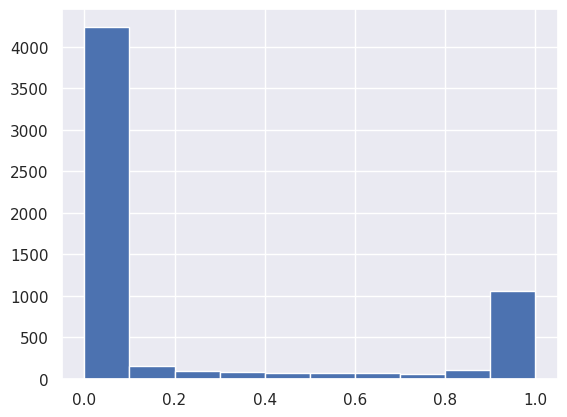

In [52]:
print(conformal_classifier.scores.shape)
print(conformal_classifier.scores[:10])
plt.hist(conformal_classifier.scores)
print(conformal_classifier.quantile)

**Exercise.** Evaluate the results by computing the average coverage and average size of the prediction sets on the test set.

In [53]:
def eval_conformal_classifier(y_true, y_predset):
    coverage = 0
    avg_length = 0
    for i in range(len(y_true)):
        if y_true[i] in y_predset[i]:
            coverage += 1
        avg_length += len(y_predset[i])


    coverage /= len(y_true)
    avg_length /= len(y_true)
    return coverage, avg_length

coverage, avg_length = eval_conformal_classifier(y_test, y_predset_test)
print(f"Average prediction intervals width (sharpness): {avg_length:.3f}")
print(f"Average coverage: {coverage:.3f}")

Average prediction intervals width (sharpness): 1.563
Average coverage: 0.901


**Exercise.** Plot 10 random images along with their prediction sets.

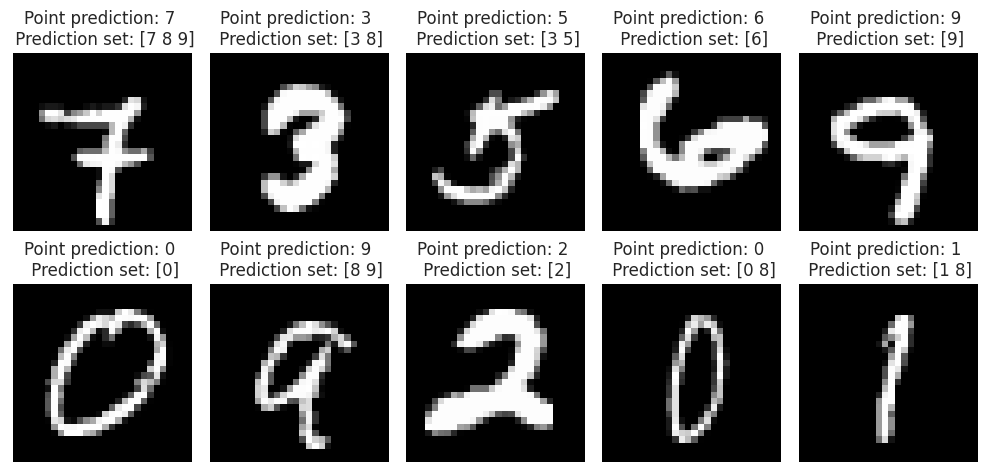

In [59]:
num_images = 10
plt.figure(figsize=(10, 5))
for i in range(num_images):
    # Select a random image and its label
    idx = torch.randint(0, len(X_test), size=(1,)).item()
    image = X_test[idx]
    ground_truth = y_test[idx]
    point_pred = y_test[idx]
    pred_set = y_predset_test[idx]

    # Denormalize the image for display
    #image = image.squeeze(0) * 0.5 + 0.5  # Convert back to [0, 1] range

    # Plot the image
    plt.subplot(2, 5, i + 1)
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(f"Point prediction: {point_pred} \n Prediction set: {pred_set}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 2. Adaptive Prediction Sets (APS)

**Exercise.** Code the `aps_score` and `aps_set` functions to be used along with the `SplitConformal` class.

In [100]:
def aps_score(probas, labels):
    scores = [probas[i, probas[i, :] >= probas[i, labels[i]]].sum() for i in range(len(probas))]
    return np.array(scores)

def aps_set(probas, quantile, rand=False):
    sorted_indices = np.argsort(-probas, axis=-1)
    sorted_probas = - np.sort(-probas, axis=-1)

    # cumulative probability masses
    sorted_cum_probas = np.cumsum(sorted_probas, axis=-1)

    # min index so that cumulative proba mass is largen than the quantile
    L = np.minimum(np.sum(sorted_cum_probas < quantile, axis=-1), len(probas[0]) - 1)
    print(L.shape)

    if not rand:
        pred_sets = [
            list(sorted_indices[i][:L[i]]) for i in range(len(probas))
        ]

    else:
        unifs = [
            np.random.uniform(min(sorted_cum_probas[i][L[i]-1], 0), sorted_cum_probas[i][L[i]])
            for i in range(len(probas))
        ]
        pred_sets = [
            list(sorted_indices[i][:L[i]]) if unifs[i] > quantile
            else list(sorted_indices[i][:L[i] - 1])
            for i in range(len(probas))
        ]

    return pred_sets


In [101]:
class APS(SplitConformal):
    def __init__(self, score_func, set_func, rand=False):
        super().__init__(score_func, set_func)
        self.rand = rand
        self.set_func = set_func

    def predict(self, probas):
        return self.set_func(probas, self.quantile, self.rand)


In [102]:
aps = APS(aps_score, aps_set, rand=True)
aps.compute_scores(probas_calib, y_calib)
aps.compute_quantile(alpha)
y_predset_test = aps.predict(probas_test)

(10000,)


1.0


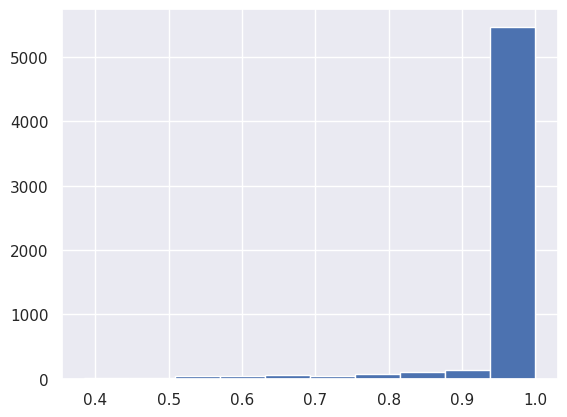

In [103]:
plt.hist(aps.scores)
print(aps.quantile)

In [104]:
coverage, avg_length = eval_conformal_classifier(y_test, y_predset_test)
print(f"Average prediction intervals width (sharpness): {avg_length:.3f}")
print(f"Average coverage: {coverage:.3f}")

Average prediction intervals width (sharpness): 5.307
Average coverage: 0.850


**Exercise.** Use the RAPS class from PUNCC and compare the results.

In [106]:
from deel.puncc.classification import RAPS

classifier = BasePredictor(model)

# Coverage target is 1-alpha = 90%
alpha = .1

# Instanciate the RAPS wrapper around the convnet predictor.
# The `train` argument is set to True such that the convnet model is trained
# before the calibration. You can initialize it to False if the model is
# already trained and you want to save time.
aps_cp = RAPS(model, lambd=0, train=True)

# The train details of the convnet are gathered in a dictionnary
fit_kwargs = {"epochs":2, "batch_size":256, "validation_split": .1, "verbose":1}

# Train model (argument `train` is True) on the fitting dataset (w.r.t. the fit config)
# and compute the residuals on the calibration dataset.
aps_cp.fit(X_fit=X_fit, y_fit=y_fit, X_calib=X_calib, y_calib=y_calib, **fit_kwargs)

# The `predict` returns the output of the convnet model `y_pred` and
# the calibrated prediction set `set_pred`.
y_pred, set_pred = aps_cp.predict(X_test, alpha=alpha)

RuntimeError: Provided model has no predict method. Use a BasePredictor or a DualPredictor to build a compatible predictor.